# Proyecto Final - WBDS- Segunda parte

***OBJETIVOS

- Obtención del genoma de Bacillus subtilis accesión CP002468.1
- Predicción de los CDS del genoma de Bacillus subtilis CP002468.1
- Búsqueda de secuencias proteínicas del genoma de Bacillus subtilis CP002468.1
- Búsqueda de dominios funcionales en las proteínas relacionadas a la ruta de la subtilisina

Empleando Jupyter, se instalaron los siguientes programas:
pip install matplotlib
pip install credentials
pip install pandas
pip install pycirclize
pip install pyrodigal
pip install requests
pip install seaborn
pip install biopython

En la carpeta de trabajo coloqué el archivo credentials.py que contiene:

from Bio import Entrez
Entrez.email   = "username@gmail.com"
Entrez.api_key = "API-KEY"

## Obtención del genoma
Se realizó la búsqueda de secuencias codificantes relacionadas a la síntesis de subtilisina de Bacillus subtilis BSn5 CP002468.1
Bacillus subtilis BSn5, complete genome

In [2]:
import credentials
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import pyrodigal
import requests
import seaborn as sns
import subprocess
import sys
from Bio import SeqIO
from Bio import Entrez
from io                 import StringIO
from matplotlib.patches import Patch
from pycirclize         import Circos
from pycirclize.parser  import Gff
from requests.adapters  import HTTPAdapter, Retry

In [24]:
accession = "CP002468.1"
genome = Entrez.efetch(db="nucleotide",
                       id=accession,
                       format="gb",
                       rettype="text")
record = SeqIO.read(genome, "genbank")
genome_length = len(record.seq)

In [4]:
#Se realizó una predicción de CDS usando pyrodigal
orf_finder = pyrodigal.OrfFinder()
orf_finder.train(bytes(record.seq))
orf_genes  = orf_finder.find_genes(bytes(record.seq))

In [5]:
aa_file = accession + ".faa"
prefix  = "Bsubtilis"
with open(aa_file, "w") as orf_gene:
    orf_genes.write_translations(orf_gene,sequence_id=prefix)
#Se generó el archivo CP002468.1.faa

In [6]:
gff_file = accession + ".gff"
prefix  = "Bsubtilis"
with open(gff_file, "w") as orf_gene:
    orf_genes.write_gff(orf_gene,sequence_id=prefix)
# Se genera el archivo CP002468.1.gff

In [7]:
uniprot_api_url  = "https://rest.uniprot.org/uniprotkb/stream"
uniprot_api_args = {"compressed" : "false",
                    "format"     : "fasta",
                    "query"      : "(subtilisin biosynthesis) AND (reviewed:true)"}
uniprot_ref_seqs = requests.get(uniprot_api_url,params=uniprot_api_args).text
#en el query se incluyó "reviewed" para aumentar la confiabilidad de los resultados

In [8]:
#Luego, las secuencias se almacenan en nuestra pc en formato fasta en el archivo "uniprot_sequences.fasta"
uniprot_seqs_file = open("uniprot_sequences.fasta", "wt")
uniprot_seqs_file.write(uniprot_ref_seqs)
uniprot_seqs_file.close()
#se generan los archivos uniprot_sequences.fasta

#Se crea una base de datos tipo blast con la creación de las secuencias de pyrodigal para encontrar secuencias similares a las obtenidas en el uniprot


In [9]:
makeblastdb_path = "/Users/Lenovo/Gianina/NCBI/blast/bin/makeblastdb"
makeblastdb_command = [makeblastdb_path,'-in',aa_file,'-dbtype','prot']
subprocess.call(makeblastdb_command)


0

#se generan los archivos: 
#CP002468.1.faa.pdb
#CP002468.1.faa.phr
#CP002468.1.faa.pin
#CP002468.1.faa.pjs
#CP002468.1.faa.pot
#CP002468.1.faa.psq
#CP002468.1.faa.ptf
#CP002468.1.faa.pto

**OBTENCIÓN DE SECUENCIAS DE INTERÉS DEL GENOMA ANALIZADO

In [10]:
blastp_path       = "/Users/Lenovo/Gianina/NCBI/blast/bin/blastp"
blastp_out_format = "6 qseqid sseqid qlen slen qstart sstart qend send score evalue length positive"
blastp_out_file   = accession + ".blast.tsv"
blastp_command    = [blastp_path,
                     "-db",          aa_file,
                     "-query",       "uniprot_sequences.fasta",
                     "-evalue",      "1e-9",
                     "-out",         blastp_out_file,
                     "-outfmt",      blastp_out_format,
                     "-num_threads", "12"]
subprocess.call(blastp_command)
#Se genera el archivo CP002468.1.blast.tsv que es una tabla
#que contiene secuencias de interés del genoma analizado

0

In [11]:
blastp_column_names = blastp_out_format.split(" ")[1:]
blastp_df = pd.read_csv(blastp_out_file,sep="\t",names=blastp_column_names)

In [12]:
candidate_genes=blastp_df["sseqid"].unique().tolist()
len(candidate_genes)

25

In [13]:
# Se transformó el archivo gff en un dataframe
gff_columns     = ["chr","source","feature_type","start","end","score","strand","phase","info"]
gff_df          = pd.read_csv(gff_file,sep="\t",comment="#",header=None,names=gff_columns)
gff_df["start"] = gff_df["start"].astype(int)
gff_df["end"]   = gff_df["end"].astype(int)

In [14]:

def get_gff_info(info_str):
    out_dict = {}
    info_arr = info_str.split(";")
    for line in info_arr:
        if "=" in line:
            line_arr    = line.split("=")
            field_name  = line_arr[0]
            field_value = line_arr[1]
            out_dict[field_name] = field_value
    return out_dict

In [15]:
gff_df["annotation"] = gff_df["info"].apply(lambda x: get_gff_info(x))

In [16]:
gff_df["candidate"] = gff_df["annotation"].apply(lambda x: "include" if x["ID"] in candidate_genes else "exclude")

In [17]:
# Se almacenó los resultados en un archivo .gff para que pycirclize l
candidate_df = gff_df.copy()
candidate_df = candidate_df[candidate_df["candidate"]=="include"][gff_columns]
candidate_df.to_csv("candidates.gff",sep="\t",header=False,index=False)
#se generó el archivo candidates.gff

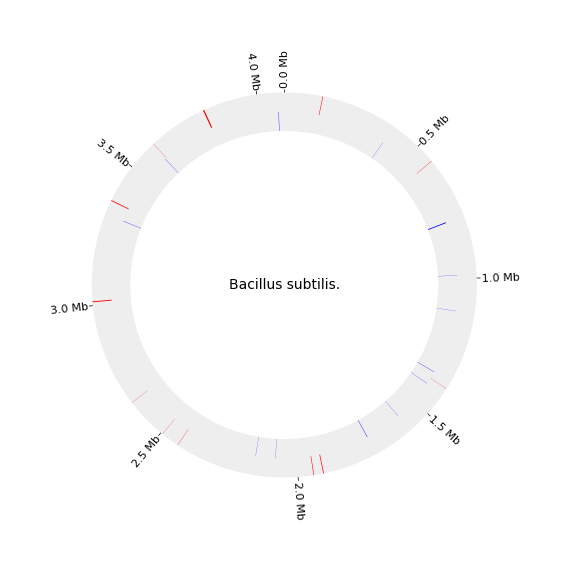

In [19]:
#Visualización en pycirclize
circos = Circos(sectors={accession: genome_length})
circos.text("Bacillus subtilis.")
circos_gff = Gff(gff_file="candidates.gff")
sector = circos.get_sector(accession)
sector = circos.sectors[0]
cds_track = sector.add_track((80, 100))
cds_track.axis(fc="#EEEEEE", ec="none")
cds_track.genomic_features(circos_gff.extract_features("CDS", target_strand =  1), r_lim=(90, 100),fc="red" )
cds_track.genomic_features(circos_gff.extract_features("CDS", target_strand = -1), r_lim=(80,  90),fc="blue")
pos_list, labels = [], []
cds_track.xticks_by_interval(
    interval=500000,
    label_formatter=lambda label_value: f"{label_value/ 1000000:.1f} Mb",
    label_orientation="vertical")
fig = circos.plotfig().set_figwidth(5)

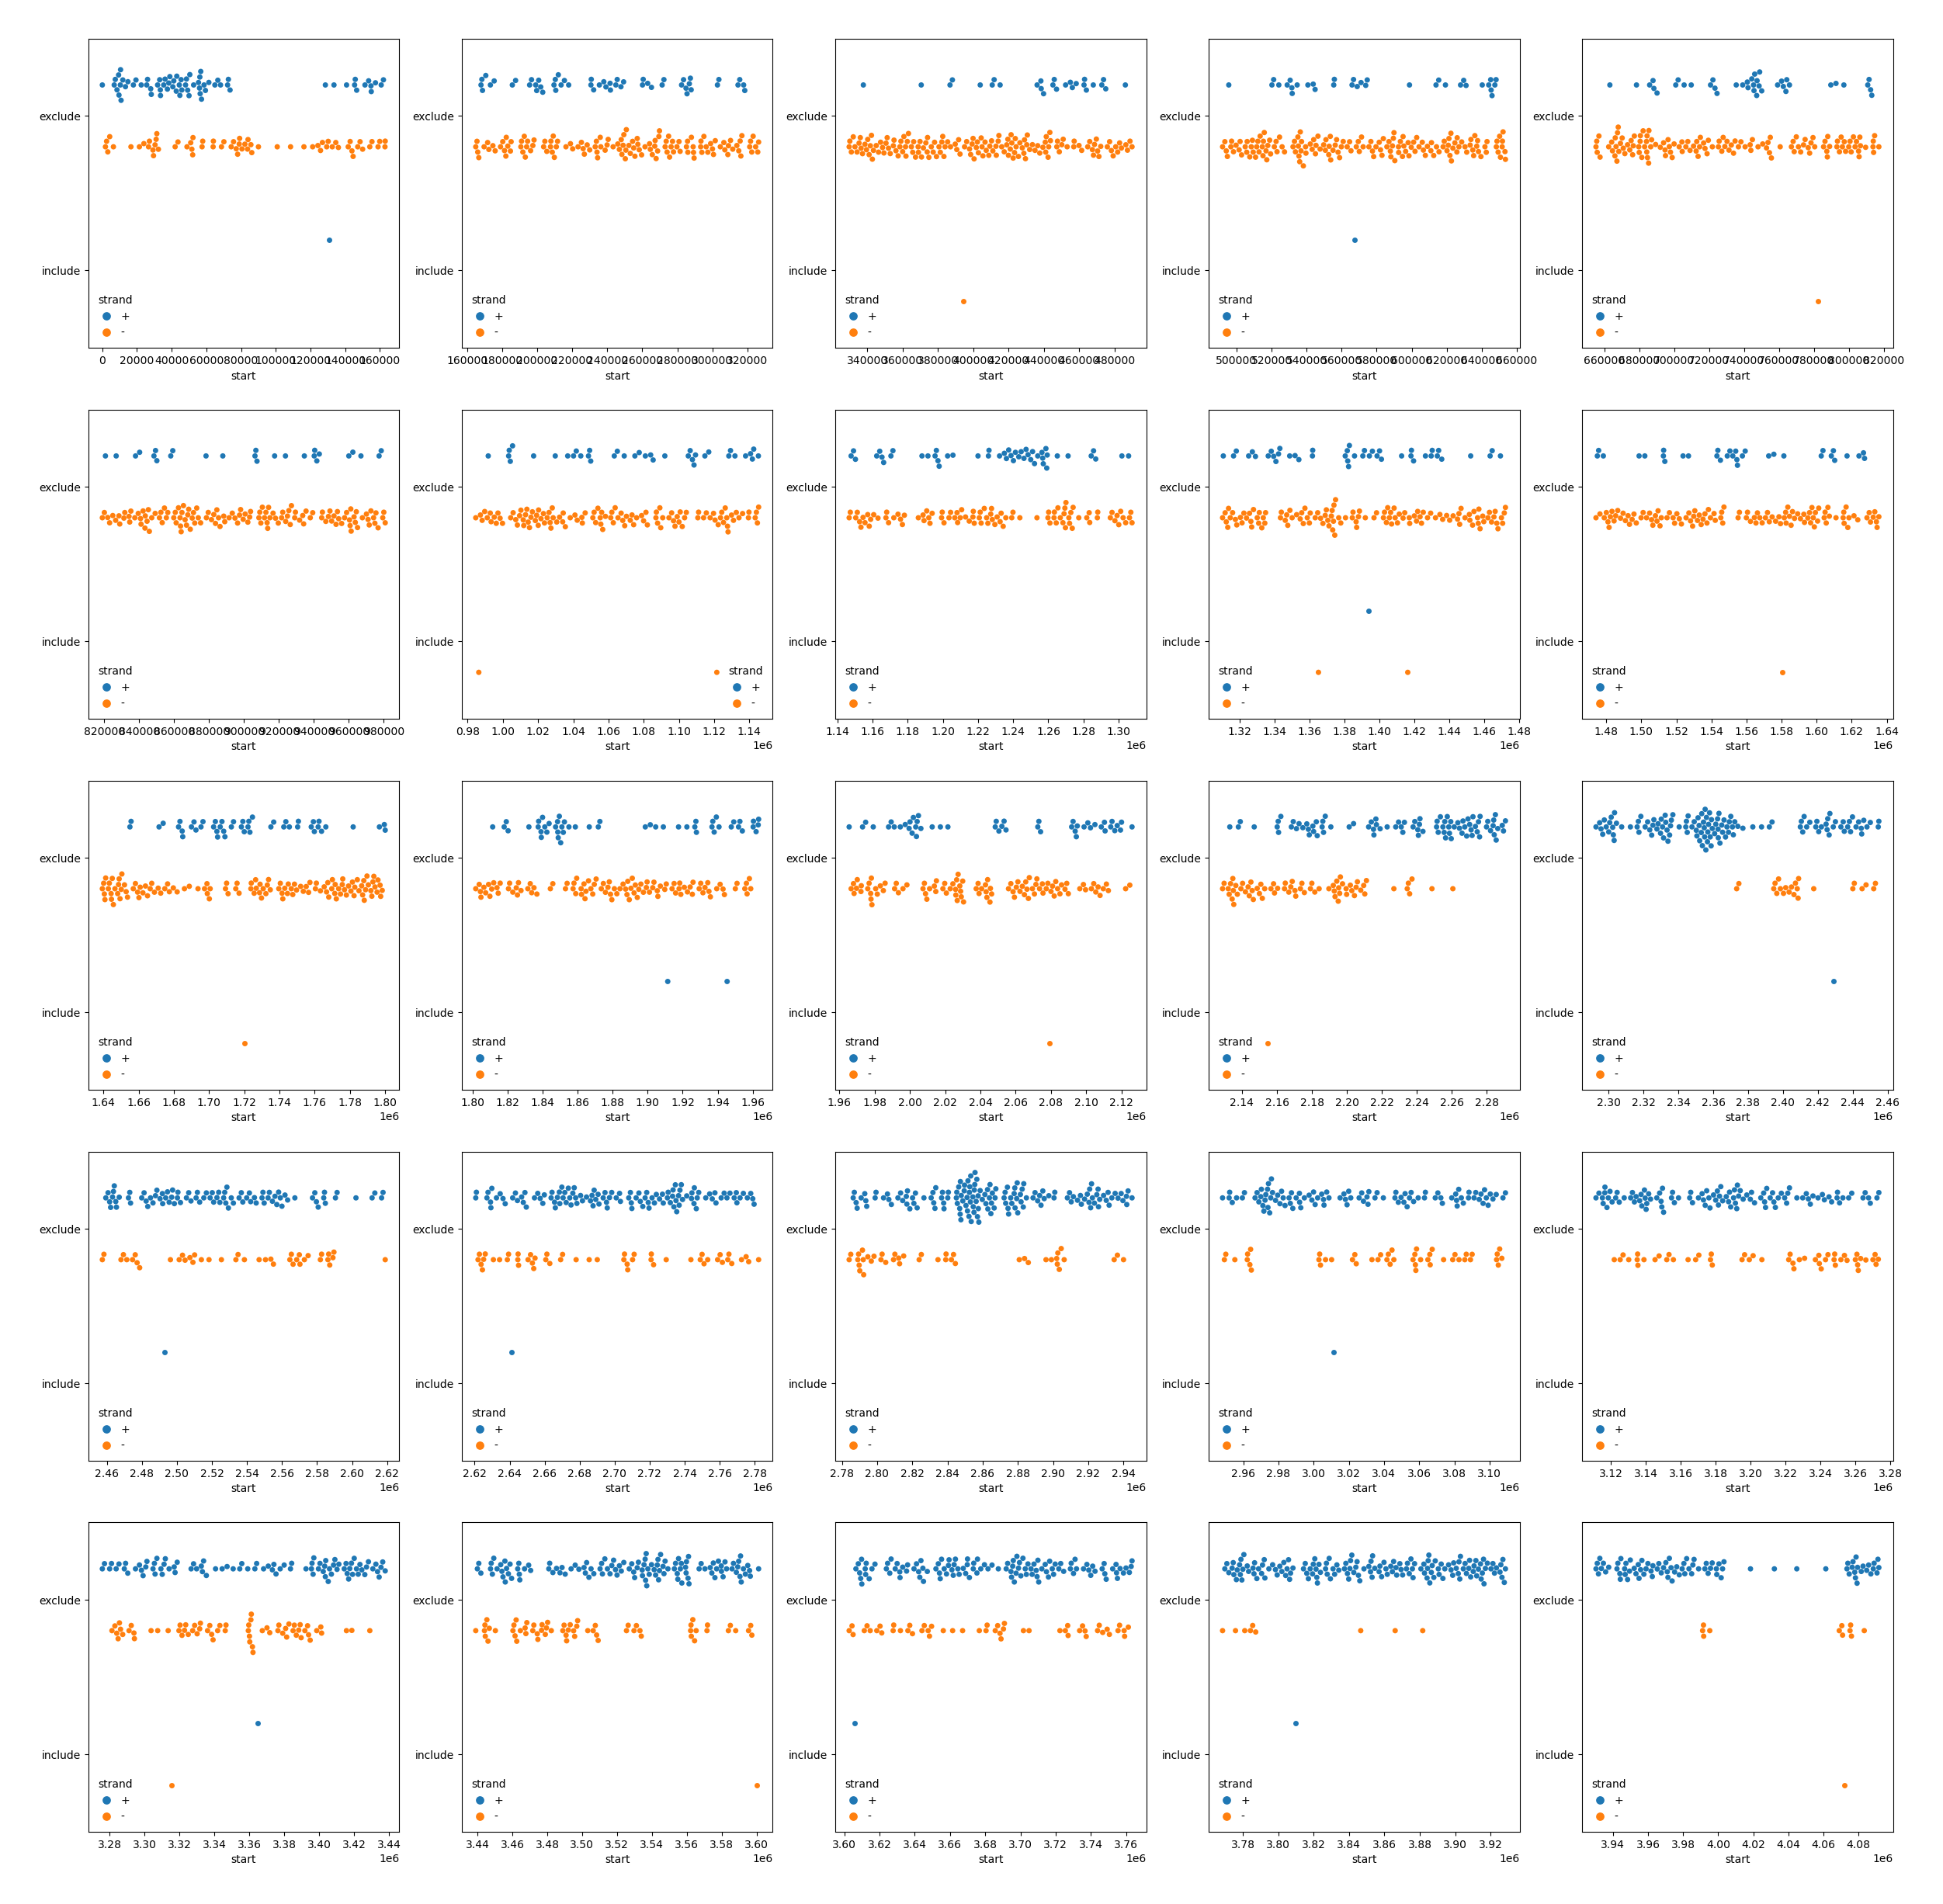

In [20]:
#Se empleó seaborn para una examinación más exhaustiva
num_bins = 25
counter_1 = 0
counter_2 = 0
fig, axes = plt.subplots(5,5,figsize=(30,30))
bin_len  = (genome_length - (genome_length % (num_bins - 1))) / (num_bins)
for bin_num in range(num_bins):
    start_pos = bin_num * bin_len
    end_pos   = (bin_num + 1) * bin_len
    mb_df = gff_df.copy()
    mb_df = mb_df[(mb_df["start"]>start_pos) & (mb_df["end"]<=end_pos)]
    sns.swarmplot(ax = axes[counter_1,counter_2],data = mb_df,y="candidate",x="start",hue="strand",dodge=True,order=["exclude","include"],hue_order=["+","-"])
    axes[counter_1,counter_2].set(ylabel=None)
    counter_2 += 1
    if (counter_2%5 == 0):
        counter_2 = 0
        counter_1 += 1
plt.show()

**Detalle del operón seleccionado

In [21]:
#Se obtienen los ID de los genes presentes en el operón
operon_df = gff_df.copy()
operon_df = operon_df[(operon_df["start"]     >= 3350000) &
                      (operon_df["end"]       <= 3450000) &
                      (operon_df["strand"]    == "-")     &
                      (operon_df["candidate"] == "include")]
operon_df.reset_index(drop=True, inplace=True)

In [22]:
operon_gene_list = []
for index in operon_df.index.tolist():
    gene_id = operon_df["annotation"][index]["ID"]
    operon_gene_list.append(gene_id)

In [23]:
#Se obtienen las secuencias aminoacídicas en formato fasta
query_str = ""

In [25]:
for record in SeqIO.parse(aa_file, "fasta"):
    seq_id  = record.id
    if(seq_id in operon_gene_list):
        seq_str = str(record.seq)
        query_str+=">"+seq_id+"\n"+seq_str+"\n"
query_str = query_str.replace("*","")
# se genera el archivo CP002468.1.blast.tsv

**RESULTADOS

Se obtuvo 4054 CDS con pyrodigal y 25 genes candidatos